# Basic Model Interface (BMI) for streamflow prediction using Long Short-Term Memory (LSTM) networks
This Long Short-Term Memory (LSTM) network was developed for use in the [Next Generation National Water Model (Nextgen)](https://github.com/NOAA-OWP/ngen). Nextgen runs models with [Basic Model Interface (BMI)](https://bmi.readthedocs.io/en/latest/).

### These libraries should all be available in the environment.yml through the command
`conda activate bmi_lstm`
#### Make sure that the library is installed
`pip install lstm`

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from netCDF4 import Dataset
from lstm import bmi_lstm  # Load module bmi_lstm (bmi_lstm.py) from lstm package.
import pickle
import xarray as xr

### Set path to the project/repo folder for the LSTM model

When the LSTM Python model is used within NextGen, this folder will be in the "ngen" folder at: ngen/extern/lstm_py, and the LSTM Python package will be at: ngen/extern/{repo_name}/{package_name}.  Note that paths to required datasets will be relative to this project folder.

You will need to set your full local path `lstm_dir` to directory where you cloned the repo


In [2]:
import sys
import os, os.path
lstm_dir = os.path.expanduser('../lstm/')
os.chdir( lstm_dir )
import pandas as pd

### This sample dataset comes from NeuralHydrology: 
These are just samples. These models can run with any forcing data. This is just a sample that is used for examples within NeuralHydrology.
https://github.com/neuralhydrology/neuralhydrology/tree/master/test/test_data/camels_us/hourly
* 02064000 Falling River nr Naruna, VA
* 01547700 Marsh Creek at Blanchard, PA
* 03015500 Brokenstraw Creek at Youngsville, PA
* 01022500 Narraguagus River at Cherryfield, Maine

In [3]:
basin_id = "01333000"

In [4]:
# Load the USGS data
file_path = f"/Users/jmframe/CAMELS_data_sample/hourly/usgs-streamflow/{basin_id}-usgs-hourly.csv"
df_runoff = pd.read_csv(file_path)
df_runoff = df_runoff.set_index("date")
df_runoff.index = pd.to_datetime(df_runoff.index)
df_runoff = df_runoff[["QObs(mm/h)"]].rename(columns={"QObs(mm/h)": "usgs_obs"})
df_runoff["model_pred"] = None
print(df_runoff.head())

                     usgs_obs model_pred
date                                    
1993-09-29 00:00:00  0.032120       None
1993-09-29 01:00:00  0.030965       None
1993-09-29 02:00:00  0.030503       None
1993-09-29 03:00:00  0.029810       None
1993-09-29 04:00:00  0.028423       None


In [5]:
forcing_file_path = f"/Users/jmframe/CAMELS_data_sample/hourly/aorc_hourly/{basin_id}_1980_to_2024_agg_rounded.csv"
df_forcing = pd.read_csv(forcing_file_path)
df_forcing = df_forcing.set_index("time")
df_forcing.index = pd.to_datetime(df_forcing.index)
df_forcing = df_forcing[df_runoff.index[0]:df_runoff.index[-1]]
print(df_forcing.head())

                     APCP_surface  DLWRF_surface  DSWRF_surface  PRES_surface  \
time                                                                            
1993-09-29 00:00:00           0.0          332.9            0.0       92940.0   
1993-09-29 01:00:00           0.0          332.7            0.0       92970.0   
1993-09-29 02:00:00           0.0          332.5            0.0       93000.0   
1993-09-29 03:00:00           0.0          317.9            0.0       93040.0   
1993-09-29 04:00:00           0.0          317.3            0.0       93000.0   

                     SPFH_2maboveground  TMP_2maboveground  \
time                                                         
1993-09-29 00:00:00              0.0065              284.3   
1993-09-29 01:00:00              0.0063              283.9   
1993-09-29 02:00:00              0.0061              283.4   
1993-09-29 03:00:00              0.0059              283.0   
1993-09-29 04:00:00              0.0058              282.3  

In [6]:
# Load in model comparison data
comparison_file_path = f"/Users/jmframe/data/nh_runs/nh_AORC_hourly_25yr_1210_112435/test/model_epoch009/{basin_id}_test_results.csv"
df_nh = pd.read_csv(comparison_file_path)
df_nh = df_nh.set_index("date")
df_nh.index = pd.to_datetime(df_nh.index)

# Ensure the time alignment with `df_runoff`
df_nh = df_nh.reindex(df_runoff.index)
if "QObs(mm/h)_sim" in df_nh.columns:
    df_runoff["nh"] = df_nh["QObs(mm/h)_sim"]

# Test the model BMI implimentation

In [8]:
# Create an instance of the LSTM model with BMI
model_instance = bmi_lstm.bmi_LSTM()

# Initialize the model with a configuration file
model_instance.initialize(bmi_cfg_file=Path(f'../bmi_config_files/{basin_id}_nh_AORC_hourly_25yr_1210_112435.yml'))

# Iterate through the forcing DataFrame and calculate model predictions
print('Working, please wait...')
for idx, row in df_forcing.iterrows():
    # Extract forcing data for the current timestep
    precip = row["APCP_surface"]
    temp = row["TMP_2maboveground"]
    dlwrf = row["DLWRF_surface"]
    dswrf = row["DSWRF_surface"]
    pres = row["PRES_surface"]
    spfh = row["SPFH_2maboveground"]
    ugrd = row["UGRD_10maboveground"]
    vgrd = row["VGRD_10maboveground"]

    # Check if any of the inputs are NaN
    if np.isnan([precip, temp, dlwrf, dswrf, pres, spfh, ugrd, vgrd]).any():
        if model_instance.verbose > 0:
            print(f"Skipping timestep {idx} due to NaN values in inputs.")
        continue

    # Set the model forcings
    model_instance.set_value('atmosphere_water__liquid_equivalent_precipitation_rate', precip)
    model_instance.set_value('land_surface_air__temperature', temp)
    model_instance.set_value('land_surface_radiation~incoming~longwave__energy_flux', dlwrf)
    model_instance.set_value('land_surface_radiation~incoming~shortwave__energy_flux', dswrf)
    model_instance.set_value('land_surface_air__pressure', pres)
    model_instance.set_value('atmosphere_air_water~vapor__relative_saturation', spfh)
    model_instance.set_value('land_surface_wind__x_component_of_velocity', ugrd)
    model_instance.set_value('land_surface_wind__y_component_of_velocity', vgrd)

    # Update the model
    model_instance.update()

    # Retrieve and scale the runoff output
    dest_array = np.zeros(1)
    model_instance.get_value('land_surface_water__runoff_depth', dest_array)
    land_surface_water__runoff_depth = dest_array[0] * 1000  # Convert to mm/hr

    # Add the output to the DataFrame
    df_runoff.loc[idx, "model_pred"] = land_surface_water__runoff_depth

# Ensure "model_pred" is numeric
df_runoff["model_pred"] = pd.to_numeric(df_runoff["model_pred"], errors="coerce")

# Calculate NSE for the model predictions
obs = df_runoff["usgs_obs"].dropna()
sim = df_runoff["model_pred"].dropna()

# Align indices of observation and simulation for metric calculation
common_index = obs.index.intersection(sim.index)
obs = obs.loc[common_index].values
sim = sim.loc[common_index].values

denominator = ((obs - obs.mean()) ** 2).sum()
numerator = ((sim - obs) ** 2).sum()
nse = 1 - numerator / denominator
print(f"NSE: {nse:.2f}")

Will not print anything except errors because verbosity set to 0
self.verbose 0
Working, please wait...


/Users/jmframe/miniconda3/envs/bmi_lstm/lib/python3.10/site-packages/lstm/bmi_lstm.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_state_dict = torch.load(trai

NSE: 0.53


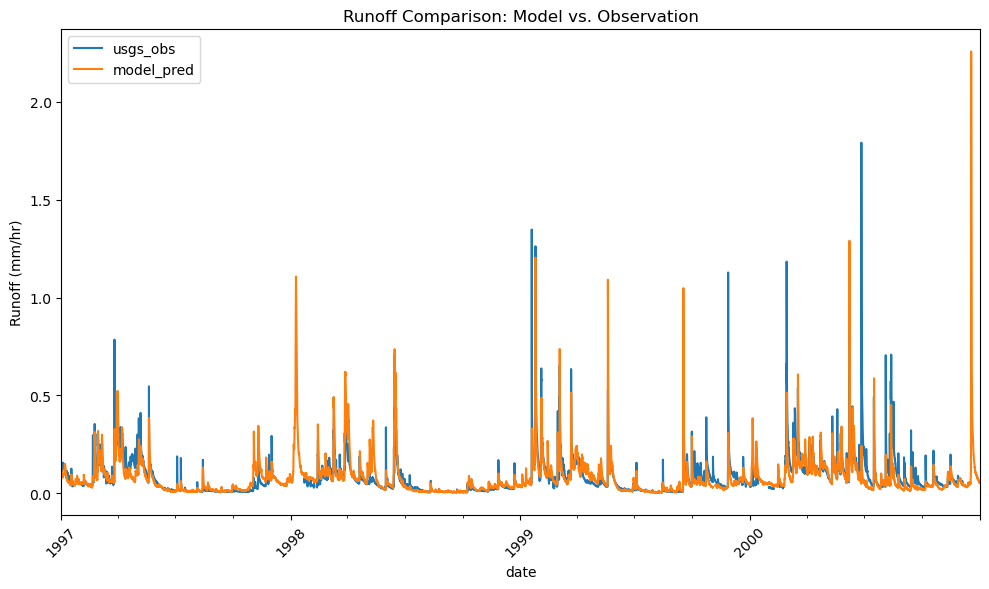

In [14]:
# Plot the runoff predictions and observations on the same y-axis
ax = df_runoff.loc['1997':'2000'].plot(
    y=["usgs_obs", "model_pred"], 
    figsize=(10, 6),
    title="Runoff Comparison: Model vs. Observation"
)
ax.set_ylabel("Runoff (mm/hr)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()